# Capstone Project - The Battle of the Neighborhoods

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project, I'll try to find the best locations to construct apartment complexes in the Colombo district in Sri Lanka, near to Colombo city. Mainly, this report will be tragetted toward the stakeholders intreasted in constructing apartment complexes in near future.

The analysis is focused on finding locations in the vicinity of the most commonly used infrastructures since these locations will be the most apeling for the customers. Further, locations much closer to Colombo city will be removed from the analysis due to high land prices. Locations further away from Colombo city will be removed from the analysis due to the long travel time to reach the city.

I will use my data science powers to select the most promising locations to construct apartment complexes based on these criteria. Then selected locations will be passed to the stakeholder to make a decision.

## Data <a name="data"></a>

Based on the definition of our problem, factors that will influence our decision are:
* Venues and venue types in the vicinity of each location
* Distance from Colombo city to each location

I have used census data from the Department of Census and Statistics, Sri Lanka to identify the GNs (like neighborhoods) in the Colombo district.

Following data sources will be needed to extract/generate the required information:
* Location (latitude and longitude) of each GN are obtained from parsing the address to **Google Maps API**. The address of each GN is extracted from the census data.
* Distance from Colombo city to each location is obtained using **Geopy** package.
* Nearby venues of each GN location is obtained using **Foursquare API**

### Extracting Neighborhoods

I've started my analysis by downloading the census data of the Western province of Sri Lanka from Department of Census and Statistics. Unfortunately, the data was not available at analysis ready stage since the data was stored in a .pdf format. So, I had to do some pre-processing to make them suitable for anlysis.
Firstly, I've used an app named Tabula to  convert the data in .pdf file to a .csv file. Then, I had to do some manual pre processing mainly to,
* Remove the unnecessary data
* Fix some issues in the consistancy of data formatting


### Extracting Location Data

Now, I've loaded the processed neighborhood detailes of the Colombo district to a pandas dataframe. Then I've passed the address of each location to the Google Map API to extract latitude and longitude details of each location.

After appending latitude and longitude details to the dataaframe, dataframe was saved as a .csv file for future uses.

In [1]:
# import packages
import pandas as pd 
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy import GoogleV3
from geopy.distance import geodesic
import requests
from sklearn.cluster import KMeans
# visualizing plots in notebook
%matplotlib inline

In [42]:
# read the csv file to a df
colomboCensus = pd.read_csv('colomboCensus.csv')
colomboCensus.head()

,DS,GN,GN Number,Both sexes,Male,Female
0,Colombo,Sammanthranapura,NaN,"7,829","4,017","3,812"
1,Colombo,Mattakkuliya,NaN,"28,003","14,029","13,974"
2,Colombo,Modara,NaN,"17,757","8,794","8,963"
3,Colombo,Madampitiya,NaN,"12,970","6,505","6,465"
4,Colombo,Mahawatta,NaN,"8,809","4,367","4,442"


In [43]:
colomboCensus.shape

(557, 6)

In [3]:
# google maps API key
APIKEY = 'Input the API key here'

In [4]:
# define a list to store the outputs
colomboLocations = []
# get the location data of each location add to df
googleMap = GoogleV3(APIKEY)
for brough, neighborhood in zip(colomboCensus['DS'], colomboCensus['GN']):
    address = '{}, {}'.format(neighborhood, brough)
    row = {}
    # get location data using geopy
    location = googleMap.geocode(address, region='LK')
    # populate the row dict with extracted data
    row['DS'] = brough
    row['GN'] = neighborhood
    if location is not None:
        row['Latitude'] = location.latitude
        row['Longitude'] = location.longitude
    else:
        row['Latitude'] = 0
        row['Longitude'] = 0
    # add the dict to list
    colomboLocations.append(row)

GeocoderQueryError: Your request was denied.

In [2]:
# turn the location data into a df
tempDF = pd.DataFrame(colomboLocations)
# drop the DS column from df
tempDF.drop('DS', axis=1, inplace=True)

NameError: name 'pd' is not defined

In [ ]:
# change the dtypes of df columns befor join
# check the dtypes
colomboCensus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DS          557 non-null    object
 1   GN          557 non-null    object
 2   GN Number   502 non-null    object
 3   Both sexes  557 non-null    object
 4   Male        557 non-null    object
 5   Female      557 non-null    object
dtypes: object(6)
memory usage: 26.2+ KB


At this stage I've identified commas the numerical values rendered the integers as objects. So, I've removed commas from those numerical values and convert those columns to int32.

In [ ]:
# remove comas from the numeric values
colomboCensus.replace(',', '', regex=True, inplace=True)
# change the dtypes
colomboCensus = colomboCensus.astype({'Both sexes':'int32', 'Male':'int32', 'Female':'int32'})
# check the dtype after modification
colomboCensus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DS          557 non-null    object
 1   GN          557 non-null    object
 2   GN Number   502 non-null    object
 3   Both sexes  557 non-null    int32 
 4   Male        557 non-null    int32 
 5   Female      557 non-null    int32 
dtypes: int32(3), object(3)
memory usage: 19.7+ KB


In [ ]:
# check the df dtypes
tempDF.info()

In [ ]:
# join two df
colomboCensus = colomboCensus.merge(tempDF, on='GN')

In [2]:
# save the data in a .csv file
colomboCensus.to_csv('colomboCensusProcessed.csv', index=False)

NameError: name 'colomboCensus' is not defined

### Calculate the Distance

As the next step I've caluclated distance from colombo city to each GN location. For this I've used geodesic function of geopy.distance package.

After that, I've removed the GN locations closer than 5km to city, based on the higher land price. Same as that, I've removed locations further than 15km, based on longer traveling time to reach the Colombo city.


In [2]:
# open the csv file with census and geospatial data of Colombo
geospatialData = pd.read_csv('colomboCensusProcessed.csv')
geospatialData.head()

,DS,GN,GN Number,Both sexes,Male,Female,Latitude,Longitude
0,Colombo,Sammanthranapura,NaN,7829,4017,3812,6.978943,79.877983
1,Colombo,Mattakkuliya,NaN,28003,14029,13974,6.971672,79.878683
2,Colombo,Modara,NaN,17757,8794,8963,6.966925,79.871153
3,Colombo,Madampitiya,NaN,12970,6505,6465,6.961663,79.875184
4,Colombo,Mahawatta,NaN,8809,4367,4442,6.958307,79.873084


In [3]:
# drop the unwanted columns
geospatialData.drop(['GN Number', 'Both sexes', 'Male', 'Female'], axis=1, inplace=True)

In [4]:
# latitude and longitude of Colombo city
colomboLocation = [6.926523627315386, 79.85483152436545]
# add a column to df to store the distance from Colombo city to each GN location
geospatialData['Distance from Colombo'] = None
# calculate the distance from GN location to Colombo city and populate the column
for latitude, longitude, index in zip(geospatialData['Latitude'], geospatialData['Longitude'], geospatialData.index):
    distanceColombo = geodesic([latitude, longitude], colomboLocation).km
    geospatialData.at[index, 'Distance from Colombo'] = distanceColombo
geospatialData.head()

,DS,GN,Latitude,Longitude,Distance from Colombo
0,Colombo,Sammanthranapura,6.978943,79.877983,6.336563
1,Colombo,Mattakkuliya,6.971672,79.878683,5.646016
2,Colombo,Modara,6.966925,79.871153,4.818306
3,Colombo,Madampitiya,6.961663,79.875184,4.489975
4,Colombo,Mahawatta,6.958307,79.873084,4.052534


In [5]:
# drop the locations more than 15km away from the city
geospatialData = geospatialData[(geospatialData['Distance from Colombo']<15)]
# drop the locations closer than 5km to city
geospatialData = geospatialData[(geospatialData['Distance from Colombo']>5)]
geospatialData.reset_index(drop=True, inplace=True)
geospatialData.head()

,DS,GN,Latitude,Longitude,Distance from Colombo
0,Colombo,Sammanthranapura,6.978943,79.877983,6.336563
1,Colombo,Mattakkuliya,6.971672,79.878683,5.646016
2,Kolonnawa,Halmulla,6.953490,79.895480,5.391848
3,Kolonnawa,Kittampahuwa,6.943663,79.900379,5.378471
4,Kolonnawa,Maha Buthgamuwa B,6.945843,79.909475,6.405504


In [6]:
# visualize the selected locations
# create a map object
colomboMap = folium.Map(location=colomboLocation, zoom_start=11)
# add markers of GN locations to map
for latitude, longitude, label in zip(geospatialData['Latitude'], geospatialData['Longitude'], geospatialData['GN']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=True
        ).add_to(colomboMap)
# visuallize the Colombo city location in red color
folium.CircleMarker(
    colomboLocation,
    radius=2,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=True
    ).add_to(colomboMap)
# visualize the map
colomboMap

### Get Nearby Venues

Then, I've used the Foursquare API to ge the nearby venues of each selected GN location.



In [7]:
# Foursqure credentials
CLIENT_ID = 'VU2AEMY2CCFAIDMYNX4GGHA1IISEQ5KHVOQH3OWEEW5VUK2U' # Foursquare ID
CLIENT_SECRET = '0BEY2YJ2OF1CWXVC1Z23QKN10YWGCV0CQ4DQBGL3OVEOMJ3Q' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Following venue categories are selected as most appealing infrastucture categories for the customers.
- Transport facilities
- Educational facilities
- Recreational facillities
- Medical facilities

However, to seperate industrial and city areas from residential areas following venue categories also selected to gather the details.
- Residential buildings
- Factories
- Offices

In [8]:
categories = {
    'Road': '4bf58dd8d48988d1f9931735',
    'Intersection': '52f2ab2ebcbc57f1066b8b4c',
    'Bus station': '4bf58dd8d48988d1fe931735',
    'Bus stop': '52f2ab2ebcbc57f1066b8b4f',
    'Train station': '52f2ab2ebcbc57f1066b8b51',
    'Residence': '4e67e38e036454776db1fb3a',
    'School': '4bf58dd8d48988d13b941735',
    'Office': '4bf58dd8d48988d124941735',
    'Medical center': '4bf58dd8d48988d104941735',
    'Factory': '4eb1bea83b7b6f98df247e06',
    'Recreation': '4d4b7105d754a06377d81259'
}


In [12]:
# loop counter
i = 0
# create a list to store the venues
venues = []
# looping through the categories
for category in categories.keys():   
    # looping through the df to get the nerby venue details
    for latitude, longitude, gn in zip(geospatialData['Latitude'], geospatialData['Longitude'], geospatialData['GN']):
            # request url
            url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                categories[category], 
                latitude, 
                longitude, 
                1000, # only concider 1,000m radius around the selected location
                LIMIT)
            try:
                # create a get request
                results = requests.get(url).json()['response']['venues']
                # append venue details to the list
                _tempVenueList = []
                for venue in results:
                    _tempVenueList.append((gn, 
                                        latitude,
                                        longitude,
                                        venue['name'],
                                        venue['location']['lat'],
                                        venue['location']['lng'],
                                        category))
            except:
                pass
            venues.append(_tempVenueList)

            # progress indicator
            i = i+1
            print('\rPrecentage complete: {}%'.format(
                round(i*100/(geospatialData.shape[0]*len(categories.keys())), 2)), end='')


Precentage complete: 100.0%

In [13]:
# convert the list to df
nearbyVenues = pd.DataFrame([item for venue in venues for item in venue])
# add column names to df
nearbyVenues.columns = ['GN',
              'GN Latitude',
              'GN Longitude',
              'Venue',
              'Venue Latitude',
              'Venue Longitude',
              'Venue Category']


In [15]:
# save the venue list into csv file
nearbyVenues.to_csv('nearbyVenues.csv', index=False)

## Methodology <a name="methodology"></a>

In this project I'll try to find the neghborhoods in Colombo district, which are sorrounded by the basic infrastuctures.

In the first step, I have collected the neighborhoods in Colombo district using census data. Then I use the google map API to get latitude and longitude of each neighborhood. Then I've remove the locations much closer and far away from the Colombo city.

As the second step, I've collected nearby venue data of selected neighborhoods using Foursquare API.

In the third step, I'll cluster the location based on the nearby venues using K-means clustering method. Based on the clustering results I'll select what are the most suitable locations to construct apartment buildings.

## Analysis <a name="analysis"></a>

In [16]:
# one hot encoding
colomboVenues = pd.get_dummies(nearbyVenues[['Venue Category']], prefix="", prefix_sep="")
# add GN column to the df
colomboVenues['GN'] = nearbyVenues['GN']
# rearranging the columns
columnNames = ['GN']+[columnName for columnName in list(colomboVenues.columns) if columnName != 'GN']
colomboVenues = colomboVenues[columnNames]
colomboVenues.head()

,GN,Bus station,Bus stop,Factory,Intersection,Medical center,Office,Recreation,Residence,Road,School
0,Himbutana West,0,0,0,0,0,0,0,0,1,0
1,Malpura,0,0,0,0,0,0,0,0,1,0
2,Thalangama North B,0,0,0,0,0,0,0,0,1,0
3,Thalahena South,0,0,0,0,0,0,0,0,1,0
4,Muttettugoda,0,0,0,0,0,0,0,0,1,0


There are lot of restaurant types in the dataframe. But I do not required different types of restaurants for clustering. So, I added the all restaurant tupes to a single column.


In [147]:
# create a copy of df
_temp = colomboVenues.copy()
# listing restaurant categories
restaurants = []
for venue in _temp.columns:
    if 'restaurant' in venue.lower():
        restaurants.append(venue)
# sum up all restaurants into single column
_temp['Restaurants'] = _temp.loc[:, restaurants].sum(axis=1)
# drop the unwanted columns
_temp.drop(restaurants, axis=1, inplace=True)

There are lot of shop types in the dataframe. But I do not required different types of restaurants for clustering. So, I added the all restaurant tupes to a single column.


In [148]:
# listing restaurant categories
shops = []
for venue in _temp.columns:
    if 'shop' in venue.lower() or 'store' in venue.lower():
        shops.append(venue)
# sum up all restaurants into single column
_temp['Shops'] = _temp.loc[:, shops].sum(axis=1)
# drop the unwanted columns
_temp.drop(shops, axis=1, inplace=True)


In [150]:
# resassaign the df
colomboVenues = _temp.copy()

In [17]:
# group the venues
colomboGroupedVenues = colomboVenues.groupby('GN').mean()
colomboGroupedVenues.reset_index(inplace=True)
colomboGroupedVenues.head()

,GN,Bus station,Bus stop,Factory,Intersection,Medical center,Office,Recreation,Residence,Road,School
0,Ambathale,0.062500,0.0,0.1875,0.0,0.062500,0.187500,0.312500,0.187500,0.0,0.000000
1,Angulana North,0.000000,0.0,0.0000,0.0,0.200000,0.133333,0.400000,0.266667,0.0,0.000000
2,Angulana South,0.000000,0.0,0.0000,0.0,0.250000,0.083333,0.416667,0.250000,0.0,0.000000
3,Arangala,0.111111,0.0,0.0000,0.0,0.111111,0.444444,0.222222,0.000000,0.0,0.111111
4,Aruppitiya,0.100000,0.0,0.0000,0.0,0.200000,0.300000,0.200000,0.050000,0.0,0.150000


In [18]:
# removing labels from df
colomboClusteringVenues = colomboGroupedVenues.drop('GN', axis=1)

Elbow method will use to get the optimum number of clusters.

In [29]:
# elbow method is used to get the optimum number of clusters
nClusters = [i for i in range(1, 10)]
sumofSquaredError = []

for nCluster in nClusters:
    kMeans = KMeans(nCluster, random_state=0).fit(colomboClusteringVenues)
    sumofSquaredError.append(kMeans.inertia_)

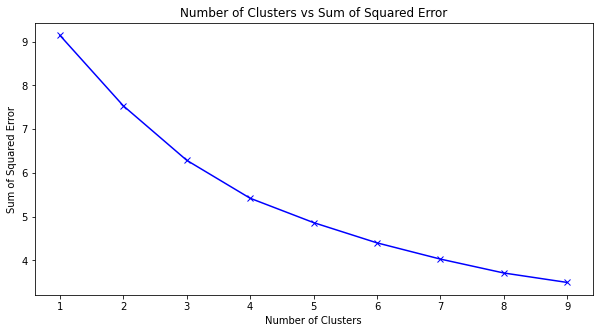

In [30]:
# plot the sum of squared error against cluster number
plt.figure(figsize=(10, 5))
plt.plot(nClusters, sumofSquaredError, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error')
plt.title('Number of Clusters vs Sum of Squared Error')
plt.show()

In [31]:
# based on above figure, select number of clusters
k = 3
# redo the clustering for the selected number of clusters
kMeans = KMeans(k, random_state=0).fit(colomboClusteringVenues)

In [32]:
# identify the common properties of each cluster
# adding cluster labels to df
colomboClustered = colomboGroupedVenues.copy()
colomboClustered.insert(1, 'Cluster Labels', kMeans.labels_)
# Merge the df with geospatialData df
colomboClustered = geospatialData.join(
    colomboClustered.set_index('GN'), on='GN')
colomboClustered.reset_index(inplace=True, drop=True)
colomboClustered.head()

,DS,GN,Latitude,Longitude,Distance from Colombo,Cluster Labels,Bus station,Bus stop,Factory,Intersection,Medical center,Office,Recreation,Residence,Road,School
0,Colombo,Sammanthranapura,6.978943,79.877983,6.336563,1,0.043478,0.000000,0.217391,0.0,0.000000,0.217391,0.478261,0.043478,0.0,0.000000
1,Colombo,Mattakkuliya,6.971672,79.878683,5.646016,0,0.044444,0.022222,0.311111,0.0,0.044444,0.266667,0.222222,0.088889,0.0,0.000000
2,Kolonnawa,Halmulla,6.953490,79.895480,5.391848,1,0.066667,0.000000,0.233333,0.0,0.100000,0.200000,0.333333,0.033333,0.0,0.033333
3,Kolonnawa,Kittampahuwa,6.943663,79.900379,5.378471,0,0.047619,0.000000,0.047619,0.0,0.285714,0.380952,0.095238,0.095238,0.0,0.047619
4,Kolonnawa,Maha Buthgamuwa B,6.945843,79.909475,6.405504,0,0.071429,0.000000,0.142857,0.0,0.142857,0.285714,0.214286,0.071429,0.0,0.071429


In [33]:
# group the rows based on cluster labels
groupedCluster = colomboClustered.drop(
    ['DS', 'GN', 'Latitude', 'Longitude', 'Distance from Colombo'], axis=1)
groupedCluster = groupedCluster.groupby('Cluster Labels').mean()
groupedCluster.reset_index(inplace=True)
groupedCluster.head()

,Cluster Labels,Bus station,Bus stop,Factory,Intersection,Medical center,Office,Recreation,Residence,Road,School
0,0,0.083307,0.007843,0.056933,0.000671,0.142632,0.349115,0.216891,0.092331,0.002365,0.047913
1,1,0.046683,0.014201,0.058241,0.000000,0.160356,0.205452,0.290273,0.195783,0.003465,0.025546
2,2,0.103720,0.010244,0.099003,0.002439,0.301053,0.194889,0.160905,0.087614,0.006330,0.033803


In [34]:
# define a function to get most common venues
def getCommonVenues(row, venueCount):
    categories = row.iloc[1:]
    sortedCategories = categories.sort_values(ascending=False)
    return sortedCategories.index[0:venueCount]

In [35]:
# creating df with most common properties of each cluster
# number of common venues
venueCount = 10
indicators = ['st', 'nd', 'rd']
# create a list of column names
columnNames = ['Cluster Labels']
for i in range(venueCount):
    if i < len(indicators):
        columnNames.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
    else:
        columnNames.append('{}th Most Common Venue'.format(i+1))
# create a df with new column names
clusterProperties = pd.DataFrame(columns=columnNames)
clusterProperties['Cluster Labels'] = groupedCluster['Cluster Labels']
# filling other columns of the df
for i in range(groupedCluster.shape[0]):
    clusterProperties.iloc[i, 1:] = getCommonVenues(
        groupedCluster.iloc[i, :], venueCount)
clusterProperties

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Office,Recreation,Medical center,Residence,Bus station,Factory,School,Bus stop,Road,Intersection
1,1,Recreation,Office,Residence,Medical center,Factory,Bus station,School,Bus stop,Road,Intersection
2,2,Medical center,Office,Recreation,Bus station,Factory,Residence,School,Bus stop,Road,Intersection


In [36]:
# based on above classification, locations in cluster 0 are more suitable to construct the apartment buildings.
# visulaize the cluster locations on a map
colomboMap = folium.Map(location=colomboLocation, zoom_start=11)
# set colors for different clusters
x = np.arange(k)
y = [1+x+x**2 for i in range(k)]
colorArray = cm.rainbow(np.linspace(0, 1, len(y)))
rainbow = [colors.rgb2hex(i) for i in colorArray]
# add markers to map
for latitude, longitude, label, cluster in zip(colomboClustered['Latitude'],
                                               colomboClustered['Longitude'],
                                               colomboClustered['GN'],
                                               colomboClustered['Cluster Labels']):
    label = folium.Popup(label + '\nCluster' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=True
    ).add_to(colomboMap)
# show the map
colomboMap


## Results and Discussion <a name="results"></a>

Based on the above analysis, we have found that areas with cluster label 1 is most suitable for constructiong apartment complexes. Neighborhoods relevent to cluster label 1 are listed in following cell.

In [41]:
colomboClustered[colomboClustered['Cluster Labels'] == 1].iloc[:, 0:4]

,DS,GN,Latitude,Longitude
0,Colombo,Sammanthranapura,6.978943,79.877983
2,Kolonnawa,Halmulla,6.953490,79.895480
6,Kolonnawa,Ambathale,6.941203,79.940256
12,Kolonnawa,Dahampura,6.801663,79.877983
13,Moratuwa,Dahampura,6.801663,79.877983
...,...,...,...,...
168,Kesbewa,Boralesgamuwa West C,6.843016,79.896180
169,Kesbewa,Rattanapitiya,6.847747,79.901078
170,Kesbewa,Egodawatta,6.850509,79.906676
171,Kesbewa,Boralesgamuwa East A,6.842517,79.903877


## Conclusion <a name="conclusion"></a>

The purpose of this excersise was to find best locations to constuct apartment complexes based on the nearby venues. I have started the evaluaton with 577 neighborhoods in Colombo district. Based on the distance and nearby venues I have eliminated 497 locations and came up with 80 preferable neighborhoods to constuct apartments.

Final decission on optimum locations to constuct apartment will be made by stakeholders taking into account other factors such as land price.